In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import linregress
import seaborn as sns
import pymc3 as pm
import arviz as az
import plot_helpers
import data_helpers
from data_helpers import gate_dataframe, canonical_data_frame
from sklearn.mixture import GaussianMixture 

# Loading the Negative Controls data

In [46]:
df = pd.read_csv('negative_controls.csv')

In [3]:
df.shape[0]

1880086

In [4]:
df['strain_name'].unique()

array(['WT-Live-Control'], dtype=object)

In [5]:
if 'level_0' in df.columns:
    df.drop(columns='level_0', inplace=True)

In [6]:
df['inc_time_1_hrs'].unique(), df['inc_time_2_hrs'].unique()

(array([18, 16]), array([18, 15,  8, 16, 10, 12]))

In [47]:
df.set_index(['strain_name', 'inc_temp_degrees', 'inc_time_2_hrs', 'media', 'od', 'plate_id', 'replicate', 'event'], drop=True, inplace=True)

In [8]:
df['FSC_A'].max(), df['SSC_A'].max()

(1048575.0, 1048575.0)

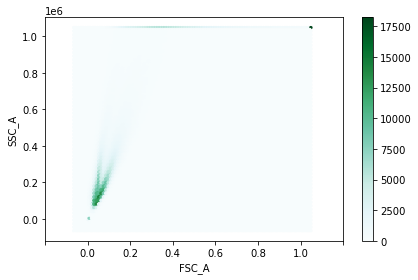

In [9]:
figure, ax = plt.subplots(1, 1)
df.plot.hexbin(x='FSC_A', y='SSC_A', ax=ax)
plt.gca().set_xlabel('FSC_A')
oticks, olabels = plt.xticks()
ticks, labels = plt.xticks(ticks=oticks, labels=['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', ''])
labels = plt.gca().set_xticklabels(['', '0.0', '0.2', '0.4', '0.6', '0.8', '1.0', ''])
plt.tight_layout()
plt.gcf().savefig('saturation_heatmap.pdf', format='pdf')


# Gate the Negative Control Data

In [10]:
odf = df.copy()

In [48]:
df = odf.copy()
if 'lab_id' not in df.index.names:
    df.set_index('lab_id', append=True, drop=True, inplace=True)
if 'well' not in df.index.names:
    df.set_index('well', append=True, drop=True, inplace=True)
print(df.index.names)
df = gate_dataframe(df)

[None, 'lab_id', 'well']


# Remove data with 16h recovery time

There are not many of these -- only three plates -- and they were done with an earlier version of the protocol.  They also seem to have other oddities.

In [49]:
levels = df.index.names
dupes = {x for x in levels if levels.count(x) > 1}
dupes

set()

In [50]:
for dupe in dupes:
    levels = df.index.names
    pos = levels.index(dupe)
    df = df.droplevel(pos)

In [14]:
df.reset_index(inplace=True, drop=False)

In [15]:

df[df['inc_time_1_hrs'] == 16].lab_id.unique()

array(['r1c5va9wyf3mx_r1c63bjzu5ruy'], dtype=object)

In [16]:
df[df['inc_time_1_hrs'] == 18].lab_id.unique()

array(['r1c7cprv7fe49_r1c7jmje3ebhc', 'r1c7cpu9nj2bu_r1c7fg23qkzph',
       'r1c7cpvfzqprk_r1c7fbvba55db', 'r1c84xvquwxth_r1c8ek7vcmdxh',
       'r1c84xwx57y95_r1c8ejz8jfg9z', 'r1c84xzc5dbuv_r1c8axrywctwb',
       'r1c84y3r9yqxb_r1c8auwvzbgt3', 'r1c8xx6qe9eea_r1c93enbf48t7',
       'r1c8xx7we38vw_r1c93cukfcxqp', 'r1c8xx94j94u7_r1c93ajvdzxz5',
       'r1c8yx25rrtag_r1c96v2w8x5pq', 'r1c8yydkumrkr_r1c96xsxw79c9',
       'r1c8yyg9gxbme_r1c96wn43pq45', 'r1c9tpmcezpk2_r1c9wjnedp92f',
       'r1cbajqru7kbe_r1cbe9p9zu6dh', 'r1cbut2pdjtwv_r1cc6qzwcd4hx',
       'r1cbut3veu2z4_r1cc6efukqtxx', 'r1cbut53kpf3n_r1cc3bn2s2aj8',
       'r1cckyeq9r358_r1ccqgmy5ffcd', 'r1cckyh56hjqj_r1ccpyjef2vca',
       'r1ccqfbz332u8_r1cctaf8r32rc', 'r1cctw6h5fsfg_r1ccx3axsj5ua',
       'r1cctw7qh3777_r1ccwxr4t3wb6', 'r1cdcerdbpda2_r1cdfphfehzq2',
       'r1cdcesknarkf_r1cdfg4x5uuwp', 'r1cdcetsvxgc2_r1cdfa6jrtssc',
       'r1cdfr4bjcnrg_r1cdnuqex83dm', 'r1cdfsf4ezew3_r1cdjsyza79sr',
       'r1ce3p4vgfu3p_r1ceebve8d6t

In [51]:
df = df[df['inc_time_1_hrs'] == 18]

# Add logs for scatter values

In [52]:
df.loc[:, 'log_FSC_A'] = np.log10(df.FSC_A + 1)
df.loc[:, 'log_SSC_A'] = np.log10(df.SSC_A + 1)

Drop bad log values

In [53]:
rs = {
    'log_FSC_A': np.inf, 
    'log_FSC_A': -np.inf,
    'log_SSC_A': np.inf, 
    'log_SSC_A': -np.inf,
     }
df = df.replace(to_replace=rs, value=np.nan)
df.dropna(subset=['log_FSC_A', 'log_SSC_A'], inplace=True)

In [54]:
# df.to_csv('gated_negative_controls.csv')

# Try to make models with simple regression

## Unimodal

In [38]:
df.log_FSC_A.values, df.log_SSC_A.values

(array([4.85311998, 4.67276265, 4.61557132, ..., 4.59636614, 4.92842146,
        4.87836666]),
 array([5.53189641, 5.48825874, 5.38165288, ..., 4.97894249, 5.42656656,
        5.31249682]))

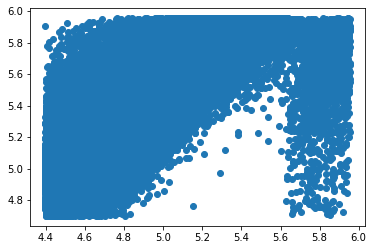

In [39]:
plt.scatter(df.log_FSC_A.values, df.log_SSC_A.values)

<AxesSubplot:xlabel='FSC_A', ylabel='SSC_A'>

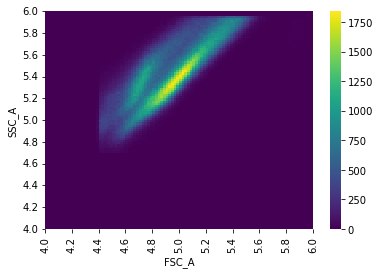

In [40]:
plot_helpers.make_heatmap(plot_helpers.point_cloud_to_histogram(df, logscale=True), logscale=True)

# Try simple linear regression

In [41]:

lr_result = linregress(df.log_FSC_A.values, df.log_SSC_A.values)
lr_result

LinregressResult(slope=0.8799736457572653, intercept=1.0964177226622844, rvalue=0.8082327739205487, pvalue=0.0, stderr=0.0006487783147381919, intercept_stderr=0.0032024821205543785)

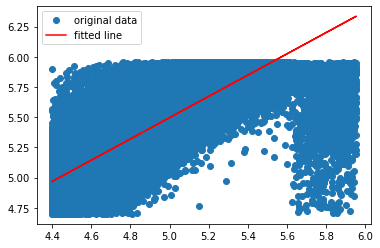

In [53]:
def plot_regression(x, y, res):
    ax = plt.subplot(111)
    
    ax.plot(x, y, 'o', label='original data')

    ax.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
    
    plt.legend()

    plt.show()
    
plot_regression(df.log_FSC_A, df.log_SSC_A, lr_result)

# Discovered what looks like two populations

There seem to be two populations in the above picture, based on the relationship between FSC_A and SSC_A.  Here we investigate this further.

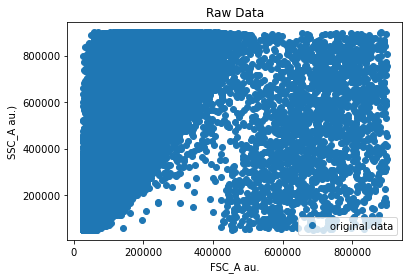

In [88]:
def plot_data(x, y):
    ax = plt.subplot(111)
    
    ax.plot(x, y, 'o', label='original data')
    
    plt.title("Raw Data")
    
    plt.legend()
    
    plt.xlabel('FSC_A au.')
    plt.ylabel('SSC_A au.)')
    
plot_data(df.FSC_A, df.SSC_A)

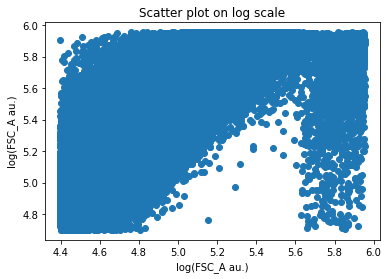

In [84]:
plt.scatter(df.log_FSC_A.values, df.log_SSC_A.values)
plt.title('Scatter plot on log scale')
plt.xlabel('log(FSC_A au.)')
plt.ylabel('log(SSC_A au.)');

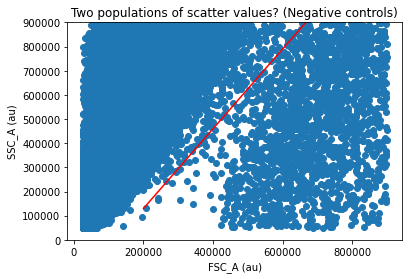

In [72]:
def separate_clusters(df):
    plt.scatter(df.FSC_A, df.SSC_A)
    xs = np.linspace(200_000, 900_000, 100)
    ys = 1.65 * xs - 200_000
    plt.gca().plot(xs, ys, color='red')
    plt.gca().set_ylim(0, 900_000)
    plt.xlabel('FSC_A (au)')
    plt.ylabel('SSC_A (au)')
    plt.title('Two populations of scatter values? (Negative controls)')


separate_clusters(df)

/home/rpg/anaconda3/envs/replication/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


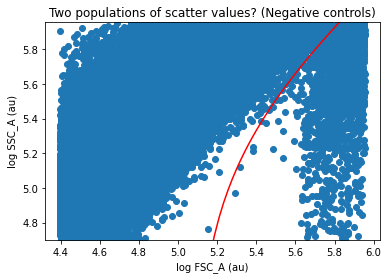

In [81]:
def separate_clusters(df):
    plt.scatter(df.log_FSC_A, df.log_SSC_A)
    new_df=pd.DataFrame()
    new_df['FSC_A'] = np.linspace(20_000, 900_000, 100)
    new_df['SSC_A'] = 1.65 * new_df['FSC_A'] - 200_000
    new_df['log_FSC_A'] = np.log10(new_df['FSC_A'])
    new_df['log_SSC_A'] = np.log10(new_df['SSC_A'])
    new_df.replace(np.Inf, np.nan, inplace=True)
    new_df.replace(np.NINF, np.nan, inplace=True)
    new_df.dropna(inplace=True)

    plt.gca().plot(new_df['log_FSC_A'], new_df['log_SSC_A'], color='red')
    plt.gca().set_ylim(4.7, np.log10(900_000))
    plt.xlabel('log FSC_A (au)')
    plt.ylabel('log SSC_A (au)')
    plt.title('Two populations of scatter values? (Negative controls)')


separate_clusters(df)

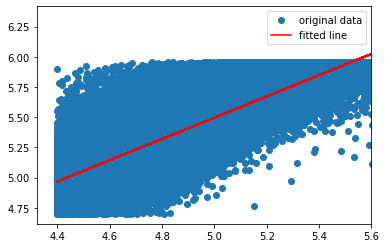

In [52]:
def plot_regression(x, y, res):
    ax = plt.subplot(111)
    
    ax.plot(x, y, 'o', label='original data')

    ax.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
    
    low_x, _ = ax.get_xlim()
    ax.set_xlim(low_x, 5.6)
#     ax.set_ylim(4, 6)

    plt.legend()

    plt.show()
    
plot_regression(df.log_FSC_A, df.log_SSC_A, lr_result)

# Try generating new linear regression with filtered data

In [95]:
def filtered_df(idf):
    return idf[idf['SSC_A'] > 1.65 * idf['FSC_A'] - 200_000]

def filtered_lin_regress(idf):
    df = filtered_df(idf)
    lr_result = linregress(df.log_FSC_A.values, df.log_SSC_A.values)
    return lr_result

new_lr = filtered_lin_regress(df)
new_lr

LinregressResult(slope=0.8971291445158214, intercept=1.0130734303341802, rvalue=0.8149648482859624, pvalue=0.0, stderr=0.0006461629578303226, intercept_stderr=0.0031883651173879248)

In [96]:
filtered_df(df).shape

(974701, 41)

In [99]:
df.shape[0] - filtered_df(df).shape[0]

1869

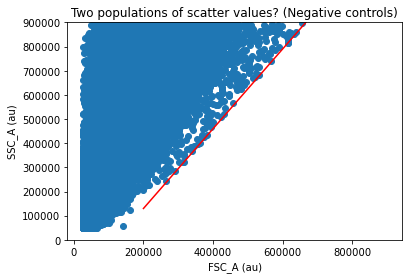

In [97]:
def separate_clusters(df):
    plt.scatter(df.FSC_A, df.SSC_A)
    xs = np.linspace(200_000, 900_000, 100)
    ys = 1.65 * xs - 200_000
    plt.gca().plot(xs, ys, color='red')
    plt.gca().set_ylim(0, 900_000)
    plt.xlabel('FSC_A (au)')
    plt.ylabel('SSC_A (au)')
    plt.title('Two populations of scatter values? (Negative controls)')


separate_clusters(filtered_df(df))

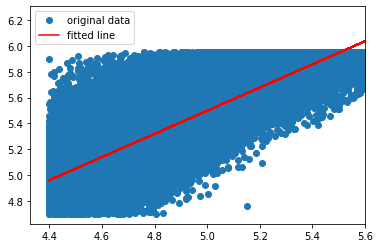

In [98]:
def plot_regression(x, y, res):
    ax = plt.subplot(111)
    
    ax.plot(x, y, 'o', label='original data')

    ax.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')
    
    low_x, _ = ax.get_xlim()
    ax.set_xlim(low_x, 5.6)
#     ax.set_ylim(4, 6)

    plt.legend()

    plt.show()
    
def cell_fun(idf, lr_result):
    df = filtered_df(idf)
    plot_regression(df.log_FSC_A, df.log_SSC_A, lr_result)

cell_fun(df, new_lr)

# Clustered linear regression with GLM

Adapted [code from StackExchange](https://stackoverflow.com/a/47960321/289934).

In [101]:
x = df['log_FSC_A']
y = df['log_SSC_A']
data = np.vstack([x, y]).T
model = GaussianMixture (n_components=2).fit(data)

In [102]:
model

GaussianMixture(n_components=2)

In [104]:
model.converged_

True

In [ ]:
ax = plt.scatter(x, y, c=model.predict(data))
ax.xlim(4, 6)
ax.ylim(4, 6)
plt.show()

In [103]:
model.predict(data)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
ax = plt.scatter(x, y, c=model.predict(data))
plt.show()

# PyMC3 Results

These seem unsatisfactory: I seem to have gotten the bimodal model configuration messed up. Anyway, the linear regressions seem to work just as well.

In [22]:
with pm.Model('Unimodal Model') as model:
    df = df.dropna(subset=['log_FSC_A', 'log_SSC_A'])
    assert df.log_FSC_A.shape[0] == df.log_SSC_A.shape[0]
    
    theta = pm.TruncatedNormal('theta', mu=1, sigma=0.5, lower=0)
    beta = pm.Normal('beta', mu=0, sd=1)
    theta2 = pm.InverseGamma('theta2', alpha=1, beta=1)
    x = pm.Data('x', df.log_FSC_A.values)
    y = pm.Normal('y', mu=theta * x + beta, sd=theta2, observed=df.log_SSC_A.values)
    

In [ ]:
with model:
    res = pm.sample(tune=2000, draws=1000, return_inferencedata=True)
    
res.to_netcdf("unimodal_model.ncd")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3337 seconds.
The acceptance probability does not match the target. It is 0.9053035134478291, but should be close to 0.8. Try to increase the number of tuning steps.


In [20]:
with pm.Model('Bimodal Model') as model2:
    df = df.dropna(subset=['log_FSC_A', 'log_SSC_A'])
    assert df.log_FSC_A.shape[0] == df.log_SSC_A.shape[0]
    x = pm.Data('x', np.array([df.log_FSC_A, df.log_FSC_A]).T)
    # if these are ordered from gentler slope to steeper, then I
    # expect the outlier cluster to be thetas[1]
    thetas = pm.TruncatedNormal('theta', 
                                mu=1, sigma=0.5, 
                                lower=0, shape=(2,), 
                                transform=pm.transforms.ordered,
                               testval=np.array([1, 1.5]))
    betas = pm.Normal('beta', mu=0, sd=1, shape=2)
    theta2 = pm.InverseGamma('theta2', alpha=1, beta=1, shape=2)
    wgts = pm.Dirichlet('w', a=np.array([1, 1]))
    ys = pm.Normal.dist(mu=thetas * x + betas, sd=theta2)
    mix = pm.Mixture('obs', w=wgts, comp_dists=ys, observed=df.log_SSC_A.values)
    

In [21]:
with model2:
    res2 = pm.sample(tune=1000, draws=500, return_inferencedata=True,
                    init="adapt_diag") # try to fix twitchy sampling
    
res2.to_netcdf("bimodal_model.ncd")

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Bimodal Model_w, Bimodal Model_theta2, Bimodal Model_beta, Bimodal Model_theta]
INFO:pymc3:NUTS: [Bimodal Model_w, Bimodal Model_theta2, Bimodal Model_beta, Bimodal Model_theta]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 33400 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 33400 seconds.
The acceptance probability does not match the target. It is 0.9053392427030862, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8956666507596885, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


'bimodal_model.ncd'

In [ ]:
az.plot_posterior(res)

array([[<AxesSubplot:title={'center':'Bimodal Model_beta\n0'}>,
        <AxesSubplot:title={'center':'Bimodal Model_beta\n1'}>,
        <AxesSubplot:title={'center':'Bimodal Model_theta\n0'}>,
        <AxesSubplot:title={'center':'Bimodal Model_theta\n1'}>],
       [<AxesSubplot:title={'center':'Bimodal Model_theta2\n0'}>,
        <AxesSubplot:title={'center':'Bimodal Model_theta2\n1'}>,
        <AxesSubplot:title={'center':'Bimodal Model_w\n0'}>,
        <AxesSubplot:title={'center':'Bimodal Model_w\n1'}>]],
      dtype=object)

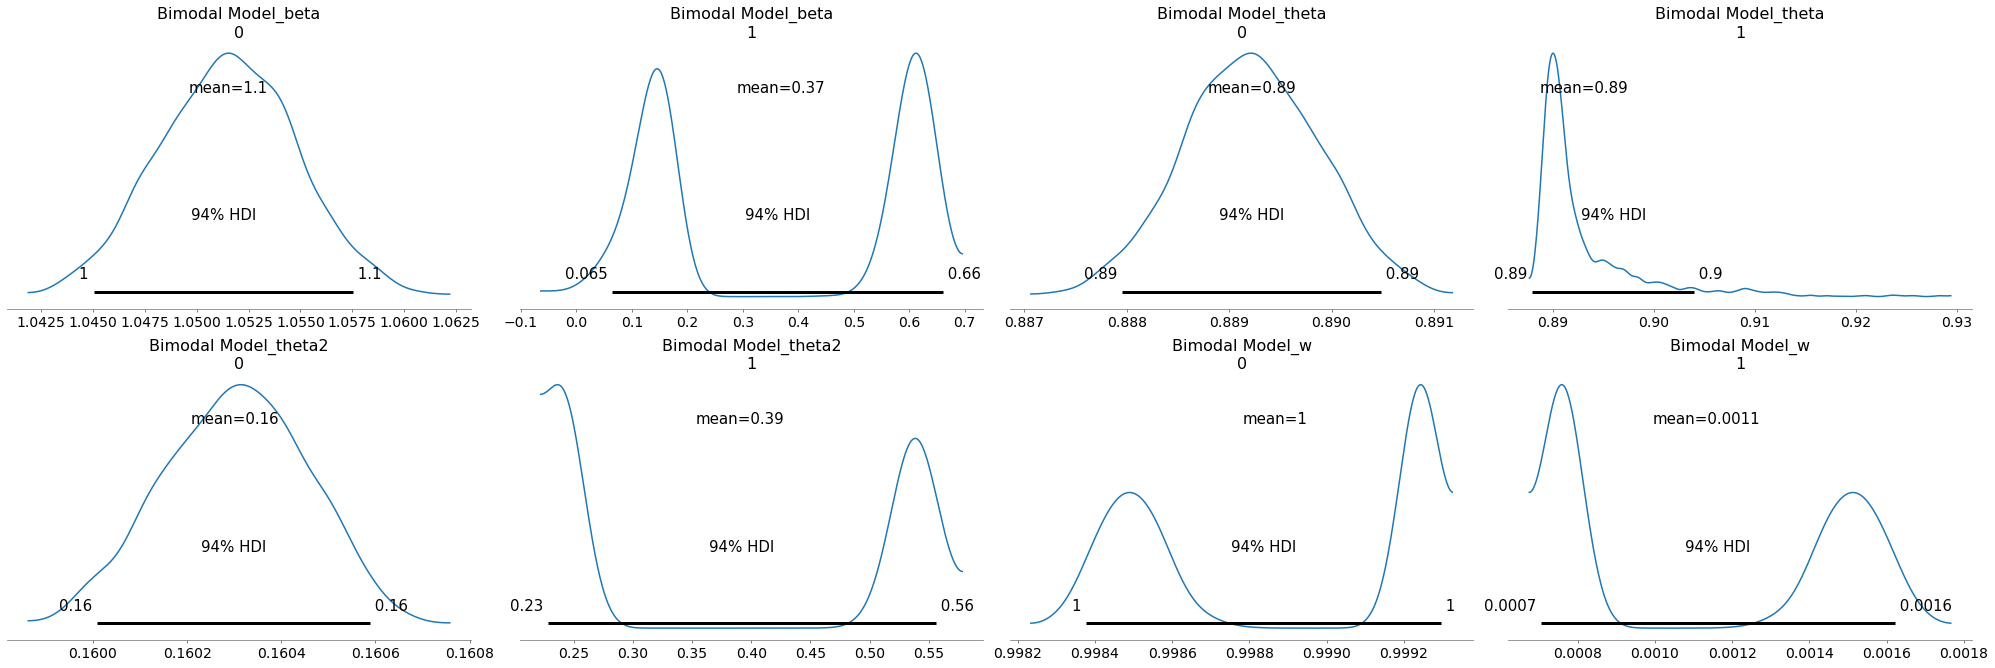

In [24]:
az.plot_posterior(res2)

# Find clusters for aggressively gated data

In [27]:
def filter_df(idf):
    df = idf.dropna(subset=['log_FSC_A', 'log_SSC_A'])
    df = df[df['log_FSC_A'] < 5.8]
    df = df[df['log_SSC_A'] < 5.8]
    df = df[df['log_FSC_A'] > 4]
    df = df[df['log_SSC_A'] > 4]
    return df

odf = df.copy()
df = filter_df(df)
assert df.log_FSC_A.shape[0] == df.log_SSC_A.shape[0]

with pm.Model('Filtered Bimodal Model') as model3:
    x = pm.Data('x', np.array([df.log_FSC_A, df.log_FSC_A]).T)
    
    thetas = pm.TruncatedNormal('theta', 
                                mu=1, sigma=0.5, 
                                lower=0, shape=(2,), 
                                transform=pm.transforms.ordered,
                               testval=np.array([1, 1.5]))
    betas = pm.Normal('beta', mu=0, sd=1, shape=2)
    theta2 = pm.InverseGamma('theta2', alpha=1, beta=1, shape=2)
    wgts = pm.Dirichlet('w', a=np.array([1, 1]))
    ys = pm.Normal.dist(mu=thetas * x + betas, sd=theta2)
    mix = pm.Mixture('obs', w=wgts, comp_dists=ys, observed=df.log_SSC_A.values)

# restore unfiltered dataframe
df = odf

In [ ]:
with model3:
    res3 = pm.sample(tune=1000, draws=500, return_inferencedata=True,
                    init="adapt_diag") # try to fix twitchy sampling
    
res3.to_netcdf("filtered_bimodal_model.ncd")

# Model with very strong priors


In [42]:
with pm.Model() as model4:
    df = df.dropna(subset=['log_FSC_A', 'log_SSC_A'])
    assert df.log_FSC_A.shape[0] == df.log_SSC_A.shape[0]
    x = pm.Data('x', np.array([df.log_FSC_A, df.log_FSC_A]).T)
    # if these are ordered from gentler slope to steeper, then I
    # expect the outlier cluster to be thetas[1]
    # first should center around 1.2, and second should center around 3 1/3
    thetas = pm.TruncatedNormal('theta', 
                                mu=[1.2, 3.3], 
                                sigma=0.5, 
                                lower=0, shape=(2,), 
                                transform=pm.transforms.ordered,
                               testval=np.array([1.2, 3.3]))
    mus = [-0.65, -10.2]
    betas = pm.Normal('beta', mu=mus, sd=1, shape=2)
    theta2 = pm.InverseGamma('theta2', alpha=1, beta=1, shape=2)
    wgts = pm.Dirichlet('w', a=np.array([1, 1]))
    mix = pm.NormalMixture('obs', w=wgts, mu=thetas * x + betas, sd=theta2, observed=df.log_SSC_A.values)


In [43]:
with model4:
    res4 = pm.sample(tune=1000, draws=500, return_inferencedata=True,
                    init="adapt_diag") # try to fix twitchy sampling
    
res4.to_netcdf("bimodal_model_strong_priors.ncd")

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, theta2, beta, theta]
INFO:pymc3:NUTS: [w, theta2, beta, theta]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 57348 seconds.
INFO:pymc3:Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 57348 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4547511533810372, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERRO

'bimodal_model_strong_priors.ncd'

array([[<AxesSubplot:title={'center':'beta\n0'}>,
        <AxesSubplot:title={'center':'beta\n1'}>,
        <AxesSubplot:title={'center':'theta\n0'}>,
        <AxesSubplot:title={'center':'theta\n1'}>],
       [<AxesSubplot:title={'center':'theta2\n0'}>,
        <AxesSubplot:title={'center':'theta2\n1'}>,
        <AxesSubplot:title={'center':'w\n0'}>,
        <AxesSubplot:title={'center':'w\n1'}>]], dtype=object)

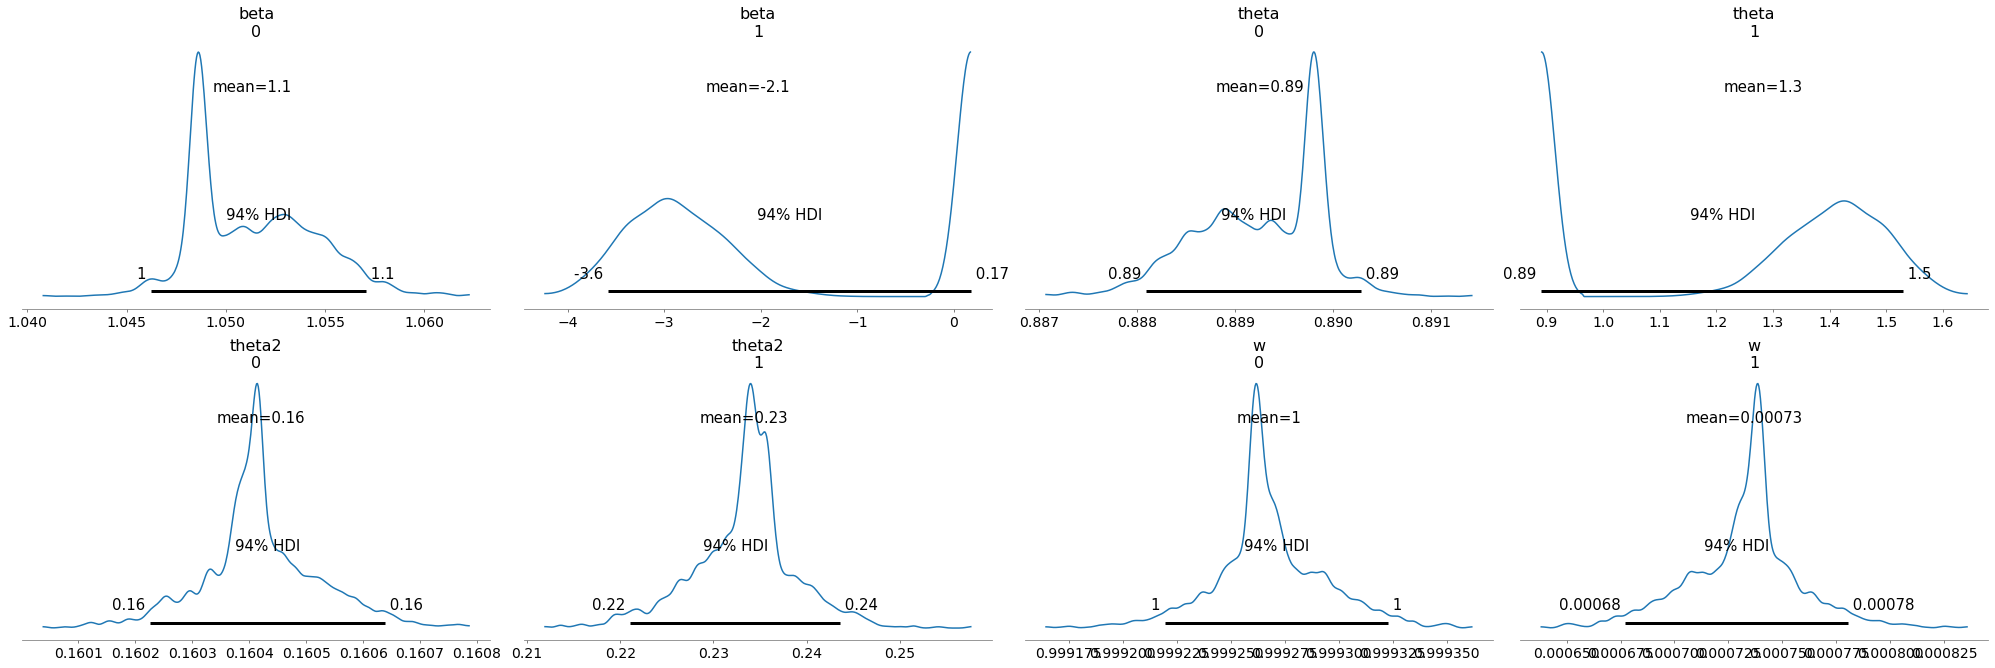

In [45]:
az.plot_posterior(res4)

# PyMC3 Model Comparisons

The following comparison suggests that the WAIC is not being computed properly for Mixture models, since this suggest that there are _more_ effective parameters in the Unimodal model than the Bimodal one, which seems _prima facie_ wrong.

In [ ]:
waic_df = az.compare({'Unimodal': res, 'Bimodal': res2}, ic='waic')
waic_df

In [ ]:
az.plot_compare(waic_df)

In [ ]:
loo_df = az.compare({'Unimodal': res, 'Bimodal': res2}, ic='loo')
loo_df

In [ ]:
az.plot_compare(loo_df)